In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/1 Decarbonization Pathways/Decarbonization_Pathways.xlsx"

# Read all sheets into a dictionary
all_sheets = pd.read_excel(file_path, sheet_name=None)

# List to hold DataFrames
df_list = []

# Iterate over each sheet
for sheet_name, df in all_sheets.items():
    df['Pathway'] = sheet_name  # Add the 'Pathway' column
    df_list.append(df)

# Concatenate all DataFrames into one
decarb_pathways = pd.concat(df_list, ignore_index=True)

In [28]:
# Old fossil fuel capacities
file_path = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/2 Generation Expansion Model/2 Generation/2 Fossil Generation/1 Existing Fossil Fuels/1 Fossil Fuels Facilities Data/Fossil_Fuel_Facilities_Data.csv"

# Read all sheets into a dictionary
Fossil_Fuels_NPC = pd.read_csv(file_path)

In [29]:
import pandas as pd

# Define the range of years
years = range(2025, 2051)

# Create an empty dictionary to store annual totals
annual_totals = {}

# Loop through each year to calculate the total
for year in years:
    # Filter out facilities retired before the current year
    active_facilities = Fossil_Fuels_NPC[(Fossil_Fuels_NPC['Retirement_year'].isna()) | (Fossil_Fuels_NPC['Retirement_year'] >= year)]
    
    # Sum up the NPC estimates for active facilities
    annual_total = active_facilities['Estimated_NameplateCapacity_MW'].sum()
    
    # Store the total for the year
    annual_totals[year] = annual_total

# Convert the dictionary to a DataFrame for better readability
Fossil_Fuels_annual = pd.DataFrame(list(annual_totals.items()), columns=['Year', 'Old fossil'])

In [30]:
# Merge the calculated totals with decarb_pathways on 'Year' and 'Pathway'
decarb_pathways = pd.merge(decarb_pathways, Fossil_Fuels_annual, on=['Year'], how='left')

In [31]:
decarb_pathways.loc[decarb_pathways['Pathway'] == 'A', 'Old fossil'] = Fossil_Fuels_annual.values[0,1]

In [32]:
# Filter the data for the year 2050
df_2050 = decarb_pathways[decarb_pathways["Year"] == 2050]

# Define colors for each energy source
colors = {
    "Old fossil": "grey",
    "New NG": "red",
    "Nuclear": "#8B0000",
    "SMR": "#FFA500",
    "Hydropower": "#00008B",
    "Biomass": "#90EE90",
    "Imports QC": "pink",
    "Imports NYISO": "#FF69B4",
    "Imports NBSO": "#FF1493",
    "Solar": "#FFD700",
    "Onshore Wind": "#ADD8E6",
    "Offshore Wind": "#87CEEB"
}
colors = {
    "Old fossil": "#D9BCA9",  # Muted grey
    "New NG": "#E9967A",      # Muted salmon
    "Nuclear": "#C27BA0",     # Pastel rose
    "SMR": "#EFD9B4",         # Muted beige
    "Hydropower": "#9EB1D4",  # Pastel blue
    "Biomass": "#A2D9B1",     # Pastel green
    "Imports QC": "#D1B1D6",  # Muted lavender
    "Imports NYISO": "#F4B6C2",# Pastel pink
    "Imports NBSO": "#F2A2B0",# Muted coral pink
    "Solar": "#FBE7A1",       # Pastel yellow
    "Onshore Wind": "#B4D6E3",# Muted light blue
    "Offshore Wind": "#A9CAD6"# Soft seafoam blue
}

# Columns in the order to stack
columns_ordered = ['Old fossil', 'Nuclear', 'Hydropower', 'Biomass', 'Imports QC',
                   'Imports NYISO', 'Imports NBSO', 'Onshore Wind',
                   'Offshore Wind', 'Solar', 'New NG', 'SMR']

# Get the unique pathways
pathways = df_2050["Pathway"].unique()

# Calculate existing assets from Pathway A
existing_assets = df_2050[df_2050["Pathway"] == "A"][columns_ordered].values[0]

# Initialize a DataFrame to store differences
differences = pd.DataFrame(columns=columns_ordered, index=pathways)

# Compute differences for each pathway compared to "Pathway A"
for pathway in differences.index:
    for i, column in enumerate(columns_ordered):
        value = df_2050[df_2050["Pathway"] == pathway][column].values[0]
        if column == "Old fossil" and pathway != "A":
            # Show Old fossil values as negatives for pathways other than "A"
            differences.at[pathway, column] = -(existing_assets[i] - value) / 1000  # Convert to GW
        elif pathway == "A":
            # For Pathway A, use the absolute values
            differences.at[pathway, column] = existing_assets[i] / 1000
        else:
            # For other technologies, calculate the positive difference
            differences.at[pathway, column] = max(value - existing_assets[i], 0) / 1000

# Ensure Old fossil difference is zero for Pathway D after the loop
differences.loc["D", "Old fossil"] = 0

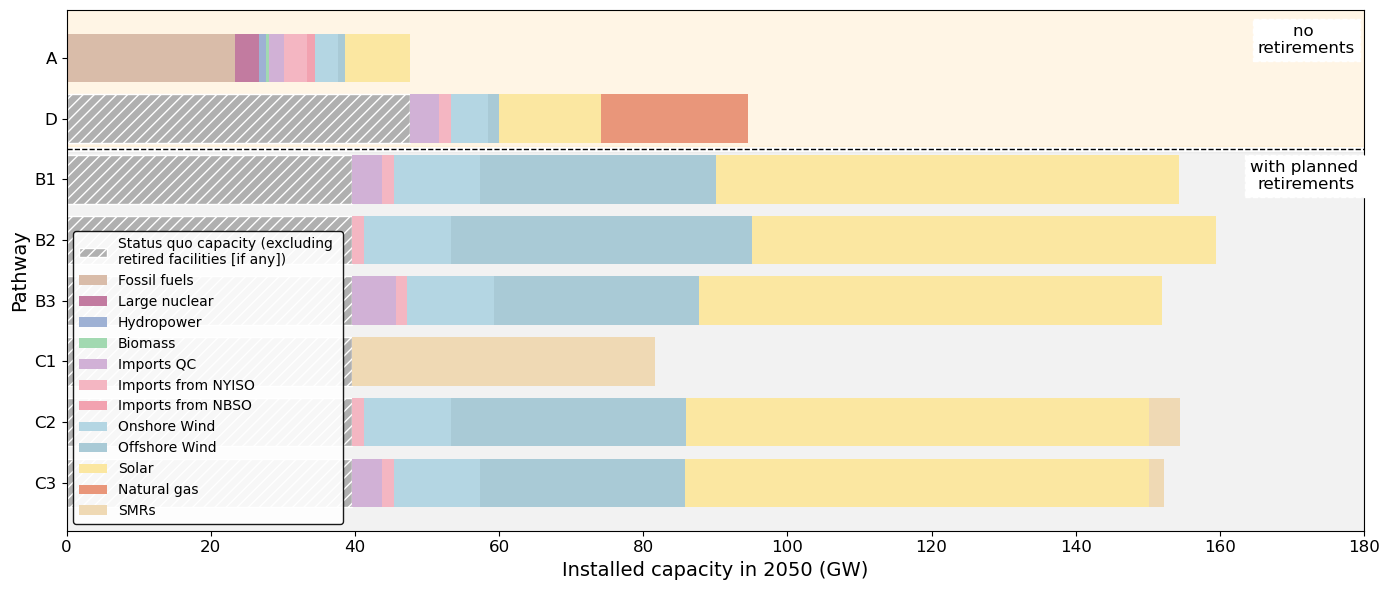

In [33]:

# Move "D" to the second of the index
differences = differences.loc[["D"] + [i for i in differences.index if i != "D"]]
differences = differences.loc[["A"] + [i for i in differences.index if i != "A"]]

# Mapping for better legend names
legend_mapping = {
    "Old fossil": "Fossil fuels",
    "Nuclear": "Large nuclear",
    "Hydropower": "Hydropower",
    "Biomass": "Biomass",
    "Imports from Hydro-Québec": "Imports from Hydro-Québec",
    "Imports NYISO": "Imports from NYISO",
    "Imports NBSO": "Imports from NBSO",
    "Onshore Wind": "Onshore Wind",
    "Offshore Wind": "Offshore Wind",
    "Solar": "Solar",
    "New NG": "Natural gas",
    "SMR": "SMRs"
}

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
y = np.arange(len(differences))  # Positions for pathways

# Initialize left values for stacking
left_vals = np.zeros(len(y))

# Add the baseline block for all pathways except "A"
baseline_values = []
for pathway in differences.index:
    if pathway == "A":
        baseline_values.append(0)  # No baseline for Pathway A
    else:
        # Total capacity of Pathway A + specific pathway's "Old fossil" difference
        baseline_values.append(
            differences.loc["A"].sum() + differences.loc[pathway, "Old fossil"]
        )

# Convert to a NumPy array for stacking
baseline_values = np.array(baseline_values)

# Plot baseline as the first block (black, hatched)
ax.barh(
    y,
    baseline_values,
    left=left_vals,
    color="#B0B0B0",
    edgecolor="white",
    hatch="///",
    label="Status quo capacity (excluding \nretired facilities [if any])"
)
# Update left values for stacking
left_vals += baseline_values

# Plot the rest of the data
for column in columns_ordered:
    if column == "Old fossil":
        # Skip "Old fossil" for all pathways except "A"
        column_data = np.where(differences.index == "A", differences[column].values.astype(float), 0)
    else:
        column_data = differences[column].values.astype(float)
    
    # Plot the bars
    ax.barh(
        y,
        column_data,
        left=left_vals,
        color=colors[column],
        label=legend_mapping.get(column, column)  # Use mapped names
    )
    
    # Update left values for stacking
    left_vals += column_data

# Add vertical line for x=0
ax.axhline(y=1.5, color="black", linewidth=1, linestyle="--")
# Add a gray rectangle on top of the graph
rect_x = 0  # Example coordinates for the rectangle
rect_width = 180
rect_y =  1.55
rect_height = 8
ax.add_patch(
    plt.Rectangle(
        (rect_x, rect_y),
        rect_width,
        rect_height,
        color="gray",
        alpha=0.1,
        zorder=-1,
        edgecolor=None  # No border
    )
)

# Add a gray rectangle on top of the graph
rect_x = 0  # Example coordinates for the rectangle
rect_width = 180
rect_y =  -1
rect_height = 2.45
ax.add_patch(
    plt.Rectangle(
        (rect_x, rect_y),
        rect_width,
        rect_height,
        color="orange",
        alpha=0.1,
        zorder=-1,
        edgecolor=None  # No border
    )
)

# Add a text box on top of the graph
ax.text(
    x=rect_x + rect_width-8 ,  # Center of the rectangle
    y=rect_y + rect_height - 1.75,  # Slightly above the rectangle
    s="no \nretirements",  # Text content
    fontsize=12,  # Font size
    ha='center',  # Horizontal alignment
    va='center',
    bbox=dict(boxstyle='square', edgecolor='white', linestyle='--', facecolor='white')  # Sharp edges with white fill and dashed black border
)

ax.text(
    x=rect_x + rect_width-8  ,  # Center of the rectangle
    y=rect_y + rect_height +.5,  # Slightly above the rectangle
    s="with planned \nretirements",  # Text content
    fontsize=12,  # Font size
    ha='center',  # Horizontal alignment
    va='center',
    bbox=dict(boxstyle='square', edgecolor='white', linestyle='--', facecolor='white')  # Sharp edges with white fill and dashed black border
)

# Add labels and legend
ax.set_xlabel("Installed capacity in 2050 (GW)", fontsize=14)  # Increase font size for x-axis label
ax.set_ylabel("Pathway", fontsize=14) 
ax.set_yticks(y)
ax.set_yticklabels(differences.index, fontsize=12)  # Increase font size for y-axis ticks
ax.tick_params(axis='x', labelsize=12)  # Set font size of x-axis tick labels
# Set the x-axis limits
ax.set_xlim(0, 180) 

# Invert the y-axis to place the first index ("A") at the top
ax.invert_yaxis()

# Configure legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicates from legend
ax.legend(
    unique_labels.values(),
    unique_labels.keys(),
    #bbox_to_anchor=(1.05, 0.5),  # Adjust anchor point
    loc='lower left',           # Align relative to anchor
    frameon=True,                # Add a border
    framealpha=0.9,              # Set border and background opacity
    fancybox=True,               # Rounded edges for the legend box
    edgecolor='black'            # Border color
)

plt.tight_layout()
plt.savefig('Decarbonization_pathways.svg', dpi=300, bbox_inches='tight')
plt.show()


## Retirements schedule

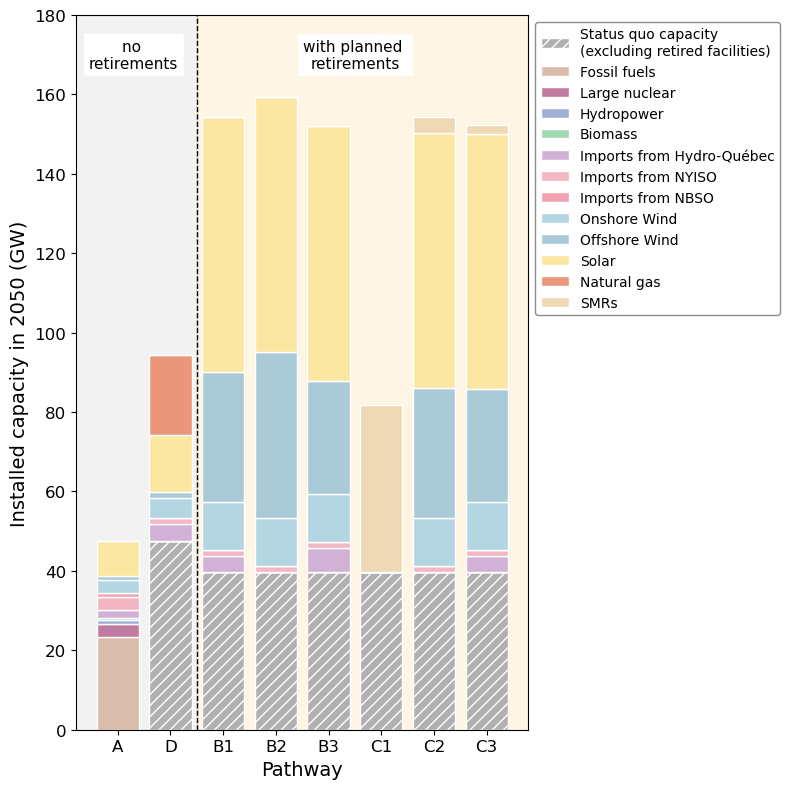

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker 

# Assuming 'differences', 'columns_ordered', and 'colors' are predefined
# Example definitions (you should replace these with your actual data)
# differences = pd.DataFrame(...)  
# columns_ordered = [...]
# colors = {...}

# Reorder the DataFrame to place "D" and "A" at desired positions
differences = differences.loc[["D"] + [i for i in differences.index if i != "D"]]
differences = differences.loc[["A"] + [i for i in differences.index if i != "A"]]

# Mapping for better legend names
legend_mapping = {
    "Old fossil": "Fossil fuels",
    "Nuclear": "Large nuclear",
    "Hydropower": "Hydropower",
    "Biomass": "Biomass",
    "Imports QC": "Imports from Hydro-Québec",
    "Imports NYISO": "Imports from NYISO",
    "Imports NBSO": "Imports from NBSO",
    "Onshore Wind": "Onshore Wind",
    "Offshore Wind": "Offshore Wind",
    "Solar": "Solar",
    "New NG": "Natural gas",
    "SMR": "SMRs"
}

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))  # Increased height for vertical layout
x = np.arange(len(differences))  # Positions for pathways

# Initialize bottom values for stacking
bottom_vals = np.zeros(len(x))

# Add the baseline block for all pathways except "A"
baseline_values = []
for pathway in differences.index:
    if pathway == "A":
        baseline_values.append(0)  # No baseline for Pathway A
    else:
        # Total capacity of Pathway A + specific pathway's "Old fossil" difference
        baseline_values.append(
            differences.loc["A"].sum() + differences.loc[pathway, "Old fossil"]
        )

# Convert to a NumPy array for stacking
baseline_values = np.array(baseline_values)

# Plot baseline as the first block (gray, hatched)
ax.bar(
    x,
    baseline_values,
    bottom=bottom_vals,
    color="#B0B0B0",
    edgecolor="white",
    hatch="///",
    label="Status quo capacity \n(excluding retired facilities)"
)
# Update bottom values for stacking
bottom_vals += baseline_values

# Plot the rest of the data
for column in columns_ordered:
    if column == "Old fossil":
        # Skip "Old fossil" for all pathways except "A"
        column_data = np.where(differences.index == "A", differences[column].values.astype(float), 0)
    else:
        column_data = differences[column].values.astype(float)
    
    # Plot the bars
    ax.bar(
        x,
        column_data,
        bottom=bottom_vals,
        color=colors[column],
        edgecolor="white",
        label=legend_mapping.get(column, column)  # Use mapped names
    )
    
    # Update bottom values for stacking
    bottom_vals += column_data

# Add horizontal line for y=0
ax.axvline(x=1.5, color="black", linewidth=1, linestyle="--")

# Add gray rectangles on the side or background as needed
# Adjust positions and dimensions for vertical layout
# Example coordinates for the rectangles
rect_width = 3  # Width of the rectangle
rect_height = 180  # Height spanning the y-axis

# First rectangle (e.g., "no retirements")
rect_x = -0.5  # Starting from the left of the first bar
rect_y = 0
ax.add_patch(
    plt.Rectangle(
        (rect_x-1, rect_y),
        rect_width,
        rect_height,
        color="gray",
        alpha=0.1,
        zorder=-1,
        edgecolor=None  # No border
    )
)

# Second rectangle (e.g., "planned retirements")
ax.add_patch(
    plt.Rectangle(
        (rect_x+2, rect_y),  # Adjust as needed
        rect_width+5,
        rect_height,
        color="orange",
        alpha=0.1,
        zorder=-1,
        edgecolor=None  # No border
    )
)

# Add text boxes on the rectangles
ax.text(
    x=rect_x + rect_width - 2.2,  # Center of the rectangle
    y=rect_y + rect_height - 10,  # Adjust vertical position
    s="no \nretirements",  # Text content
    fontsize=11,  # Font size
    ha='center',  # Horizontal alignment
    va='center',
    bbox=dict(boxstyle='square', edgecolor='white', linestyle='--', facecolor='white')  # Styling
)

ax.text(
    x=rect_x + 5,  # Center of the rectangle
    y=rect_y + rect_height  - 10,  # Adjust vertical position
    s="with planned \nretirements",  # Text content
    fontsize=11,  # Font size
    ha='center',  # Horizontal alignment
    va='center',
    bbox=dict(boxstyle='square', edgecolor='white', linestyle='--', facecolor='white')  # Styling
)

# Add labels and legend
ax.set_ylabel("Installed capacity in 2050 (GW)", fontsize=14)  # Y-axis label
ax.set_xlabel("Pathway", fontsize=14)  # X-axis label
ax.set_xticks(x)
ax.set_xticklabels(differences.index, fontsize=12, rotation=0, ha='center')  # Rotate for readability
ax.tick_params(axis='y', labelsize=12)  # Set font size of y-axis tick labels
# Set the y-axis limits
ax.set_ylim(0, 180) 

# Configure legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicates from legend
ax.legend(
    unique_labels.values(),
    unique_labels.keys(),
    loc='upper left',           # Adjust legend position
    bbox_to_anchor=(1, 1),      # Place legend outside the plot
    frameon=True,               # Add a border
    framealpha=0.9,             # Set border and background opacity
    fancybox=True,              # Rounded edges for the legend box
    edgecolor='grey'
    # Border color
)


plt.tight_layout()
plt.savefig('Decarbonization_pathways.svg', dpi=300, bbox_inches='tight')
plt.show()


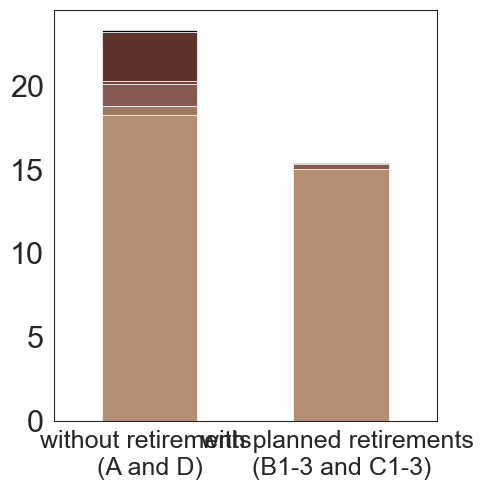

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming Fossil_Fuels_NPC is your DataFrame and is already defined
# For example:
# Fossil_Fuels_NPC = pd.read_csv('your_data.csv')

# Define the target years
target_years = [2025, 2050]

# Initialize an empty dictionary to store aggregated data
aggregated_data = {}

# Iterate over each target year to calculate the sum of capacities by fuel type
for year in target_years:
    # Filter facilities that are not retired by the target year
    filtered = Fossil_Fuels_NPC[Fossil_Fuels_NPC['Retirement_year'] >= year]
    
    # Aggregate the capacity by Primary Fuel Type
    aggregated = filtered.groupby('Primary_Fuel_Type')['Estimated_NameplateCapacity_MW'].sum()/1000
    
    # Store the aggregated data
    aggregated_data[year] = aggregated

# Convert the aggregated data into a DataFrame
capacity_by_year_and_fuel = pd.DataFrame(aggregated_data).T.fillna(0)

# Ensure the DataFrame has the target years in the desired order
capacity_by_year_and_fuel = capacity_by_year_and_fuel.loc[target_years]

# Retrieve unique fuel types
unique_fuel_types = Fossil_Fuels_NPC['Primary_Fuel_Type'].unique()

# **Define the desired stacking order based on actual fuel types**
desired_order = ['Pipeline Natural Gas', 'Coal']

# Define the specific oil types as per your data
oil_types = ['Diesel Oil', 'Other Oil', 'Residual Oil']  # Adjust if there are more oil types

# Append oil types to the desired order
desired_order += oil_types

# Append 'Wood' if it exists
if 'Wood' in unique_fuel_types:
    desired_order.append('Wood')

# Identify any remaining fuel types not specified and append them at the end
remaining_fuel_types = [ft for ft in unique_fuel_types if ft not in desired_order]
desired_order += remaining_fuel_types

# **Check for missing fuel types in the aggregated DataFrame**
missing_fuel_types = [ft for ft in desired_order if ft not in capacity_by_year_and_fuel.columns]
if missing_fuel_types:
    print(f"Warning: The following fuel types are not present in the data and will be skipped: {missing_fuel_types}")
    # Remove missing fuel types from desired_order
    desired_order = [ft for ft in desired_order if ft in capacity_by_year_and_fuel.columns]

# Reorder the DataFrame columns based on the desired stacking order
capacity_by_year_and_fuel = capacity_by_year_and_fuel[desired_order]

# **Define a muted pastel color palette**
custom_palette = {
    'Pipeline Natural Gas': '#B28E74',   # Deeper Warm Beige
    'Coal': '#9E7962',                   # Stronger Taupe
    'Diesel Oil': '#865A50',             # Rich Dusty Rose
    'Other Oil': '#72423E',              # Darker Terracotta
    'Residual Oil': '#5E342C',           # Deep Earthy Brick
    'Wood': 'black',                   # Dark Cocoa
    # Additional fuel types can follow the enhanced contrast approach
}


# Create a color list based on the desired order, using a default pastel gray if not specified
palette = [custom_palette.get(ft, '#c7c7c7') for ft in capacity_by_year_and_fuel.columns]

# Set the style to 'white' to remove grid lines
sns.set_style("white")

# Define the figure size (width, height) in inches
fig, ax = plt.subplots(figsize=(5, 5))  # Adjusted to a smaller size

# Plot the stacked bar chart
capacity_by_year_and_fuel.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=palette,
    edgecolor='white',
    linewidth=0.5
)

# Customize the plot
#ax.set_xlabel('Pathway', fontsize=14)  # Increased font size and made bold
#ax.set_ylabel('Installed fossil fuel capacity in 2050 (GW)', fontsize=14)  # Increased font size and made bold
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)

# Define custom x-axis labels
custom_x_labels = {
    2025: 'without retirements \n(A and D)',
    2050: 'with planned retirements \n(B1-3 and C1-3)'
}
ax.set_xticks(range(len(target_years)))
ax.set_xticklabels([custom_x_labels.get(year, str(year)) for year in capacity_by_year_and_fuel.index],
                   rotation=0, ha='center', fontsize=18)  # Increased font size

# **Add a legend inside the plot at the bottom right**
legend = ax.legend(title='', fontsize=12, title_fontsize=14,
                   loc='lower left', frameon=True, 
                   facecolor='white', edgecolor='none')
legend.set_alpha(0.8)  # Set transparency
plt.legend().set_visible(False)  # This will hide the legend


# Optimize layout to ensure everything fits without overlapping
plt.tight_layout()

plt.savefig('Decarbonization_pathways_retirements.svg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


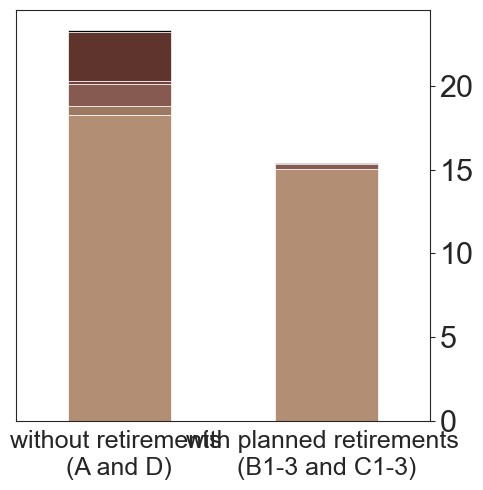

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming Fossil_Fuels_NPC is your DataFrame and is already defined
# For example:
# Fossil_Fuels_NPC = pd.read_csv('your_data.csv')

# Define the target years
target_years = [2025, 2050]

# Initialize an empty dictionary to store aggregated data
aggregated_data = {}

# Iterate over each target year to calculate the sum of capacities by fuel type
for year in target_years:
    # Filter facilities that are not retired by the target year
    filtered = Fossil_Fuels_NPC[Fossil_Fuels_NPC['Retirement_year'] >= year]
    
    # Aggregate the capacity by Primary Fuel Type
    aggregated = filtered.groupby('Primary_Fuel_Type')['Estimated_NameplateCapacity_MW'].sum()/1000
    
    # Store the aggregated data
    aggregated_data[year] = aggregated

# Convert the aggregated data into a DataFrame
capacity_by_year_and_fuel = pd.DataFrame(aggregated_data).T.fillna(0)

# Ensure the DataFrame has the target years in the desired order
capacity_by_year_and_fuel = capacity_by_year_and_fuel.loc[target_years]

# Retrieve unique fuel types
unique_fuel_types = Fossil_Fuels_NPC['Primary_Fuel_Type'].unique()

# **Define the desired stacking order based on actual fuel types**
desired_order = ['Pipeline Natural Gas', 'Coal']

# Define the specific oil types as per your data
oil_types = ['Diesel Oil', 'Other Oil', 'Residual Oil']  # Adjust if there are more oil types

# Append oil types to the desired order
desired_order += oil_types

# Append 'Wood' if it exists
if 'Wood' in unique_fuel_types:
    desired_order.append('Wood')

# Identify any remaining fuel types not specified and append them at the end
remaining_fuel_types = [ft for ft in unique_fuel_types if ft not in desired_order]
desired_order += remaining_fuel_types

# **Check for missing fuel types in the aggregated DataFrame**
missing_fuel_types = [ft for ft in desired_order if ft not in capacity_by_year_and_fuel.columns]
if missing_fuel_types:
    print(f"Warning: The following fuel types are not present in the data and will be skipped: {missing_fuel_types}")
    # Remove missing fuel types from desired_order
    desired_order = [ft for ft in desired_order if ft in capacity_by_year_and_fuel.columns]

# Reorder the DataFrame columns based on the desired stacking order
capacity_by_year_and_fuel = capacity_by_year_and_fuel[desired_order]

# **Define a muted pastel color palette**
custom_palette = {
    'Pipeline Natural Gas': '#B28E74',   # Deeper Warm Beige
    'Coal': '#9E7962',                   # Stronger Taupe
    'Diesel Oil': '#865A50',             # Rich Dusty Rose
    'Other Oil': '#72423E',              # Darker Terracotta
    'Residual Oil': '#5E342C',           # Deep Earthy Brick
    'Wood': 'black',                     # Dark Cocoa
    # Additional fuel types can follow the enhanced contrast approach
}

# Create a color list based on the desired order, using a default pastel gray if not specified
palette = [custom_palette.get(ft, '#c7c7c7') for ft in capacity_by_year_and_fuel.columns]

# Set the style to 'white' to remove grid lines
sns.set_style("white")

# Define the figure size (width, height) in inches
fig, ax = plt.subplots(figsize=(5, 5))  # Adjusted to a smaller size

# Plot the stacked bar chart
capacity_by_year_and_fuel.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=palette,
    edgecolor='white',
    linewidth=0.5
)

# Customize the plot
# ax.set_xlabel('Pathway', fontsize=14)  # Increased font size and made bold
# ax.set_ylabel('Installed fossil fuel capacity in 2050 (GW)', fontsize=14)  # Increased font size and made bold
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)

# Move y-axis tick labels to the right
ax.yaxis.tick_right()

# Define custom x-axis labels
custom_x_labels = {
    2025: 'without retirements \n(A and D)',
    2050: 'with planned retirements \n(B1-3 and C1-3)'
}
ax.set_xticks(range(len(target_years)))
ax.set_xticklabels([custom_x_labels.get(year, str(year)) for year in capacity_by_year_and_fuel.index],
                   rotation=0, ha='center', fontsize=18)  # Increased font size

# **Add a legend inside the plot at the bottom right**
legend = ax.legend(title='', fontsize=12, title_fontsize=14,
                   loc='lower left', frameon=True, 
                   facecolor='white', edgecolor='none')
legend.set_alpha(0.8)  # Set transparency
plt.legend().set_visible(False)  # This will hide the legend

# Optimize layout to ensure everything fits without overlapping
plt.tight_layout()

plt.savefig('Decarbonization_pathways_retirements.svg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


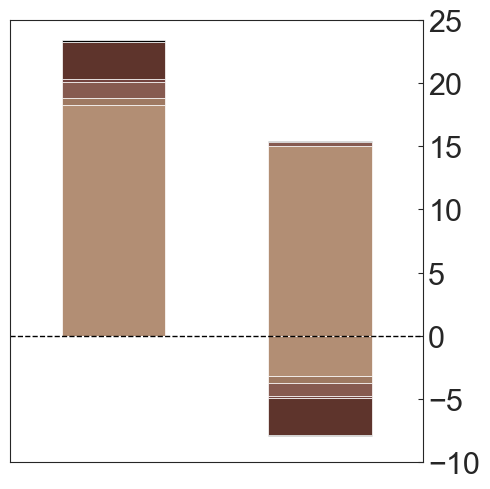

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Data Preparation ---

# Define the target years
target_years = [2025, 2050]

# Retrieve unique fuel types from your DataFrame
unique_fuel_types = Fossil_Fuels_NPC['Primary_Fuel_Type'].unique()

# Define the desired stacking order based on actual fuel types
desired_order = ['Pipeline Natural Gas', 'Coal']
oil_types = ['Diesel Oil', 'Other Oil', 'Residual Oil']  # Adjust if needed
desired_order += oil_types
if 'Wood' in unique_fuel_types:
    desired_order.append('Wood')
remaining_fuel_types = [ft for ft in unique_fuel_types if ft not in desired_order]
desired_order += remaining_fuel_types

# --- Compute Capacities for Each Scenario ---

# For 2025: only consider facilities with retirement year >=2025 (i.e. exclude retirements before 2025)
active_2025 = (Fossil_Fuels_NPC[Fossil_Fuels_NPC['Retirement_year'] >= 2025]
               .groupby('Primary_Fuel_Type')['Estimated_NameplateCapacity_MW']
               .sum() / 1000)
# For 2025, retired capacity is set to zero
retired_2025 = pd.Series(0, index=active_2025.index)

# For 2050:
# Active: facilities with retirement year >=2050 (automatically excludes any retirements before 2025)
active_2050 = (Fossil_Fuels_NPC[Fossil_Fuels_NPC['Retirement_year'] >= 2050]
               .groupby('Primary_Fuel_Type')['Estimated_NameplateCapacity_MW']
               .sum() / 1000)
# Retired: facilities retiring between 2025 (inclusive) and 2050 (exclusive)
retired_2050 = (Fossil_Fuels_NPC[(Fossil_Fuels_NPC['Retirement_year'] < 2050) & 
                                (Fossil_Fuels_NPC['Retirement_year'] >= 2025)]
                .groupby('Primary_Fuel_Type')['Estimated_NameplateCapacity_MW']
                .sum() / 1000)

# Reindex the Series to ensure they follow our desired order, filling missing with 0
active_2025 = active_2025.reindex(desired_order).fillna(0)
active_2050 = active_2050.reindex(desired_order).fillna(0)
retired_2050 = retired_2050.reindex(desired_order).fillna(0)
retired_2025 = pd.Series(0, index=desired_order)

# --- Build a DataFrame with MultiIndex Columns ---

# Create a MultiIndex for columns: first level = fuel type, second level = 'active' and 'retired'
multi_cols = pd.MultiIndex.from_product([desired_order, ['active', 'retired']])
# Initialize the DataFrame with target years as index
capacity_data = pd.DataFrame(index=target_years, columns=multi_cols)

# Fill in 2025 values: only active capacity, retired is 0
for ft in desired_order:
    capacity_data.loc[2025, (ft, 'active')] = active_2025[ft]
    capacity_data.loc[2025, (ft, 'retired')] = 0

# Fill in 2050 values: active capacity remains positive; retired capacity is made negative
for ft in desired_order:
    capacity_data.loc[2050, (ft, 'active')] = active_2050[ft]
    capacity_data.loc[2050, (ft, 'retired')] = -retired_2050[ft]  # negative so it appears below zero

# Ensure numeric type
capacity_data = capacity_data.astype(float)

# --- Define Colors and Stacking Order ---

# Define a muted pastel color palette (one color per fuel type)
custom_palette = {
    'Pipeline Natural Gas': '#B28E74',   # Deeper Warm Beige
    'Coal': '#9E7962',                   # Stronger Taupe
    'Diesel Oil': '#865A50',             # Rich Dusty Rose
    'Other Oil': '#72423E',              # Darker Terracotta
    'Residual Oil': '#5E342C',           # Deep Earthy Brick
    'Wood': 'black',                     # Dark Cocoa
    # Additional fuel types default to a pastel gray
}
# Build a palette that repeats each fuel type's color for both active and retired segments.
palette = []
for ft in desired_order:
    col = custom_palette.get(ft, '#c7c7c7')
    palette.extend([col, col])

# --- Plotting ---

sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the stacked bar chart using our multi-index DataFrame
capacity_data.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=palette,
    edgecolor='white',
    linewidth=0.5
)

# Add a horizontal dashed line at y = 0 with linewidth 1.5
ax.axhline(0, color="black", linewidth=1, linestyle="--")


# Set y ticks to be at every 5 units
ymin, ymax = ax.get_ylim()
ax.set_yticks(np.arange(np.floor(ymin / 5) * 5, np.ceil(ymax / 5) * 5 + 5, 5))
ax.tick_params(axis='y', labelsize=22)

# Ensure x ticks are displayed with default tick marks and labels
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='x', labelbottom=False)

# (Remove any extra modifications to x ticks if present)

# (No call to ax.yaxis.tick_right(), so y labels remain on the left)
ax.yaxis.tick_right()
# Ensure tick marks are drawn on both axes
ax.tick_params(which='both', direction='in')

# Remove the legend
ax.get_legend().remove()

plt.tight_layout()
plt.savefig('Decarbonization_pathways_retirements.svg', dpi=300, bbox_inches='tight')
plt.show()


In [61]:
# For 2025 (no retirements are shown)
active_2025 
retired_2025 
active_2050
retired_2050

Primary_Fuel_Type
Pipeline Natural Gas    3.1874
Coal                    0.5592
Diesel Oil              1.0181
Other Oil               0.1966
Residual Oil            2.9329
Wood                    0.0795
Name: Estimated_NameplateCapacity_MW, dtype: float64

## Updated Feb 2 2025


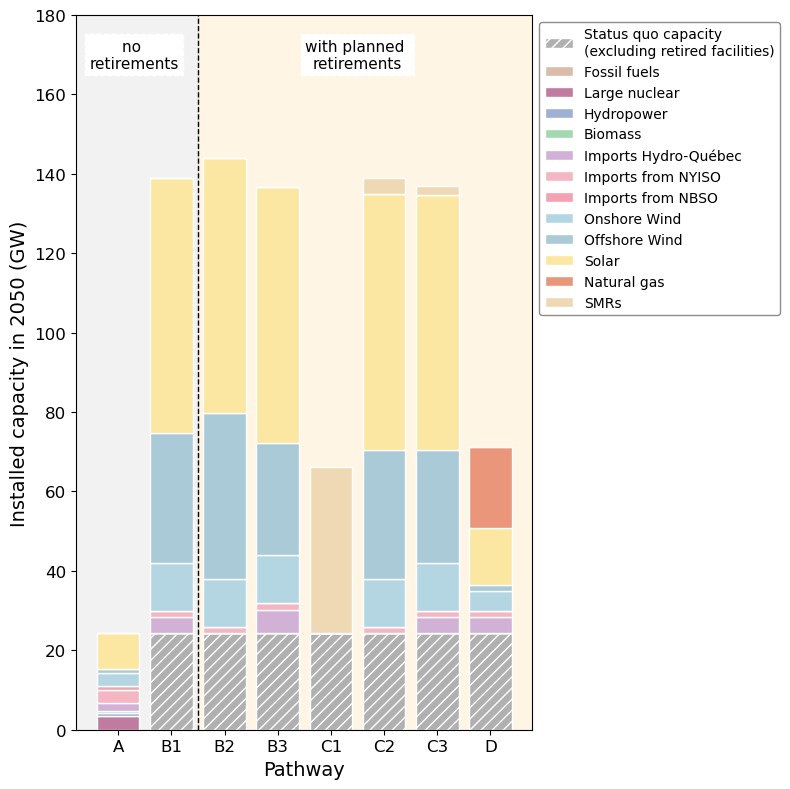

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths
decarbonization_pathways_file = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/1 Decarbonization Pathways/Decarbonization_Pathways.xlsx"
fossil_fuels_data_file = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/2 Generation Expansion Model/2 Generation/2 Fossil Generation/1 Existing Fossil Fuels/1 Fossil Fuels Facilities Data/Fossil_Fuel_Facilities_Data.csv"

# 1. Read and Combine Decarbonization Pathways
all_sheets = pd.read_excel(decarbonization_pathways_file, sheet_name=None)
decarb_pathways = pd.concat(
    [df.assign(Pathway=sheet) for sheet, df in all_sheets.items()],
    ignore_index=True
)

# 2. Read Fossil Fuels Data and Calculate Annual Totals
fossil_fuels = pd.read_csv(fossil_fuels_data_file)
years = range(2025, 2051)

annual_totals = fossil_fuels[
    fossil_fuels['Retirement_year'].isna() | (fossil_fuels['Retirement_year'] >= years.start)
].groupby('Year')['Estimated_NameplateCapacity_MW'].sum().reindex(years, fill_value=0)

fossil_fuels_annual = pd.DataFrame({
    'Year': list(years),
    'Old fossil': annual_totals.values
})

# 3. Merge and Prepare Data for 2050
decarb_pathways = decarb_pathways.merge(fossil_fuels_annual, on='Year', how='left')
decarb_pathways.loc[decarb_pathways['Pathway'] == 'A', 'Old fossil'] = fossil_fuels_annual.loc[fossil_fuels_annual['Year'] == years.start, 'Old fossil'].values[0]
df_2050 = decarb_pathways[decarb_pathways["Year"] == 2050]

# 4. Define Colors and Order for Stacking
colors = {
    "Old fossil": "#D9BCA9",
    "New NG": "#E9967A",
    "Nuclear": "#C27BA0",
    "SMR": "#EFD9B4",
    "Hydropower": "#9EB1D4",
    "Biomass": "#A2D9B1",
    "Imports QC": "#D1B1D6",
    "Imports NYISO": "#F4B6C2",
    "Imports NBSO": "#F2A2B0",
    "Solar": "#FBE7A1",
    "Onshore Wind": "#B4D6E3",
    "Offshore Wind": "#A9CAD6"
}

columns_ordered = [
    'Old fossil', 'Nuclear', 'Hydropower', 'Biomass', 'Imports QC',
    'Imports NYISO', 'Imports NBSO', 'Onshore Wind',
    'Offshore Wind', 'Solar', 'New NG', 'SMR'
]

# 5. Calculate Differences Compared to Pathway A
pathways = df_2050["Pathway"].unique()
existing_assets = df_2050[df_2050["Pathway"] == "A"][columns_ordered].values[0]

differences = pd.DataFrame(index=pathways, columns=columns_ordered)

for pathway in pathways:
    for i, column in enumerate(columns_ordered):
        value = df_2050[df_2050["Pathway"] == pathway][column].values[0]
        if column == "Old fossil" and pathway != "A":
            differences.at[pathway, column] = -(existing_assets[i] - value) / 1000  # Convert to GW
        elif pathway == "A":
            differences.at[pathway, column] = existing_assets[i] / 1000
        else:
            differences.at[pathway, column] = max(value - existing_assets[i], 0) / 1000

# Ensure "Old fossil" is zero for Pathway D and reorder pathways
differences.loc["D", "Old fossil"] = 0
differences = differences.loc[["A"] + [p for p in pathways if p != "A"]]

# 6. Define Legend Labels
legend_mapping = {
    "Old fossil": "Fossil fuels",
    "Nuclear": "Large nuclear",
    "Hydropower": "Hydropower",
    "Biomass": "Biomass",
    "Imports QC": "Imports from Hydro-Québec",
    "Imports NYISO": "Imports from NYISO",
    "Imports NBSO": "Imports from NBSO",
    "Onshore Wind": "Onshore Wind",
    "Offshore Wind": "Offshore Wind",
    "Solar": "Solar",
    "New NG": "Natural gas",
    "SMR": "SMRs"
}

# 7. Plot the Final Graph

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))  # Increased height for vertical layout
x = np.arange(len(differences))  # Positions for pathways

# Initialize bottom values for stacking
bottom_vals = np.zeros(len(x))

# Add the baseline block for all pathways except "A"
baseline_values = []
for pathway in differences.index:
    if pathway == "A":
        baseline_values.append(0)  # No baseline for Pathway A
    else:
        # Total capacity of Pathway A + specific pathway's "Old fossil" difference
        baseline_values.append(
            differences.loc["A"].sum() + differences.loc[pathway, "Old fossil"]
        )

# Convert to a NumPy array for stacking
baseline_values = np.array(baseline_values)

# Plot baseline as the first block (gray, hatched)
ax.bar(
    x,
    baseline_values,
    bottom=bottom_vals,
    color="#B0B0B0",
    edgecolor="white",
    hatch="///",
    label="Status quo capacity \n(excluding retired facilities)"
)
# Update bottom values for stacking
bottom_vals += baseline_values

# Plot the rest of the data
for column in columns_ordered:
    if column == "Old fossil":
        # Skip "Old fossil" for all pathways except "A"
        column_data = np.where(differences.index == "A", differences[column].values.astype(float), 0)
    else:
        column_data = differences[column].values.astype(float)
    
    # Plot the bars
    ax.bar(
        x,
        column_data,
        bottom=bottom_vals,
        color=colors[column],
        edgecolor="white",
        label=legend_mapping.get(column, column)  # Use mapped names
    )
    
    # Update bottom values for stacking
    bottom_vals += column_data

# Add horizontal line for y=0
ax.axvline(x=1.5, color="black", linewidth=1, linestyle="--")

# Add gray rectangles on the side or background as needed
# Adjust positions and dimensions for vertical layout
# Example coordinates for the rectangles
rect_width = 3  # Width of the rectangle
rect_height = 180  # Height spanning the y-axis

# First rectangle (e.g., "no retirements")
rect_x = -0.5  # Starting from the left of the first bar
rect_y = 0
ax.add_patch(
    plt.Rectangle(
        (rect_x-1, rect_y),
        rect_width,
        rect_height,
        color="gray",
        alpha=0.1,
        zorder=-1,
        edgecolor=None  # No border
    )
)

# Second rectangle (e.g., "planned retirements")
ax.add_patch(
    plt.Rectangle(
        (rect_x+2, rect_y),  # Adjust as needed
        rect_width+5,
        rect_height,
        color="orange",
        alpha=0.1,
        zorder=-1,
        edgecolor=None  # No border
    )
)

# Add text boxes on the rectangles
ax.text(
    x=rect_x + rect_width - 2.2,  # Center of the rectangle
    y=rect_y + rect_height - 10,  # Adjust vertical position
    s="no \nretirements",  # Text content
    fontsize=11,  # Font size
    ha='center',  # Horizontal alignment
    va='center',
    bbox=dict(boxstyle='square', edgecolor='white', linestyle='--', facecolor='white')  # Styling
)

ax.text(
    x=rect_x + 5,  # Center of the rectangle
    y=rect_y + rect_height  - 10,  # Adjust vertical position
    s="with planned \nretirements",  # Text content
    fontsize=11,  # Font size
    ha='center',  # Horizontal alignment
    va='center',
    bbox=dict(boxstyle='square', edgecolor='white', linestyle='--', facecolor='white')  # Styling
)

# Add labels and legend
ax.set_ylabel("Installed capacity in 2050 (GW)", fontsize=14)  # Y-axis label
ax.set_xlabel("Pathway", fontsize=14)  # X-axis label
ax.set_xticks(x)
ax.set_xticklabels(differences.index, fontsize=12, rotation=0, ha='center')  # Rotate for readability
ax.tick_params(axis='y', labelsize=12)  # Set font size of y-axis tick labels
# Set the y-axis limits
ax.set_ylim(0, 180) 

# Configure legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicates from legend
ax.legend(
    unique_labels.values(),
    unique_labels.keys(),
    loc='upper left',           # Adjust legend position
    bbox_to_anchor=(1, 1),      # Place legend outside the plot
    frameon=True,               # Add a border
    framealpha=0.9,             # Set border and background opacity
    fancybox=True,              # Rounded edges for the legend box
    edgecolor='grey'
    # Border color
)


plt.tight_layout()
plt.savefig('Decarbonization_pathways.svg', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths
decarbonization_pathways_file = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/1 Decarbonization Pathways/Decarbonization_Pathways.xlsx"
fossil_fuels_data_file = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/2 Generation Expansion Model/2 Generation/2 Fossil Generation/1 Existing Fossil Fuels/1 Fossil Fuels Facilities Data/Fossil_Fuel_Facilities_Data.csv"

# 1. Read and Combine Decarbonization Pathways
all_sheets = pd.read_excel(decarbonization_pathways_file, sheet_name=None)
decarb_pathways = pd.concat(
    [df.assign(Pathway=sheet) for sheet, df in all_sheets.items()],
    ignore_index=True
)

# 2. Read Fossil Fuels Data and Calculate Annual Totals
fossil_fuels = pd.read_csv(fossil_fuels_data_file)
years = range(2025, 2051)

# Filter out plants that retire before 2025
operational_fossil_fuels = fossil_fuels[
    fossil_fuels['Retirement_year'].isna() | (fossil_fuels['Retirement_year'] >= 2025)
]

# Compute total capacity
total_existing_capacity = operational_fossil_fuels['Estimated_NameplateCapacity_MW'].sum()

# Assume total capacity remains the same unless plants retire in that year
fossil_fuels_annual = pd.DataFrame({'Year': list(years), 'Old fossil': total_existing_capacity})

# Adjust for retirements in each year
for year in years:
    retiring_capacity = fossil_fuels.loc[fossil_fuels['Retirement_year'] == year, 'Estimated_NameplateCapacity_MW'].sum()
    if year > years.start:  # Deduct from previous year
        fossil_fuels_annual.loc[fossil_fuels_annual['Year'] == year, 'Old fossil'] = \
            fossil_fuels_annual.loc[fossil_fuels_annual['Year'] == year - 1, 'Old fossil'].values[0] - retiring_capacity

# Ensure no negative values
fossil_fuels_annual['Old fossil'] = fossil_fuels_annual['Old fossil'].clip(lower=0)

# 3. Merge and Prepare Data for 2050
decarb_pathways = decarb_pathways.merge(fossil_fuels_annual, on='Year', how='left')
decarb_pathways.loc[decarb_pathways['Pathway'] == 'A', 'Old fossil'] = fossil_fuels_annual.loc[fossil_fuels_annual['Year'] == years.start, 'Old fossil'].values[0]
decarb_pathways.loc[decarb_pathways['Pathway'] == 'D', 'Old fossil'] = fossil_fuels_annual.loc[fossil_fuels_annual['Year'] == years.start, 'Old fossil'].values[0]

# Extracting data for years 2025 and 2050
df_2025 = decarb_pathways[decarb_pathways["Year"] == 2025].copy()
df_2050 = decarb_pathways[decarb_pathways["Year"] == 2050].copy()

# Selecting only the capacity columns (excluding 'Year' and 'Pathway' columns)
capacity_columns = [col for col in decarb_pathways.columns if col not in ["Year", "Pathway"]]

# Creating a new DataFrame for 2050 with existing capacity and additions
df_2050_capacity = pd.DataFrame()
df_2050_capacity["Year"] = [2050] * len(df_2025)
df_2050_capacity["Pathway"] = df_2025["Pathway"].values  # Keeping the pathway column

# Calculating existing capacity and additions
for col in capacity_columns:
    df_2050_capacity[f"{col} Existing"] = df_2025[col].values
    df_2050_capacity[f"{col} Additions"] = df_2050[col].values - df_2025[col].values

# Move 'D' to the top if it exists
df_2050_capacity = pd.concat([
    df_2050_capacity[df_2050_capacity["Pathway"] == "D"],
    df_2050_capacity[df_2050_capacity["Pathway"] != "D"]
])

# Move 'A' to the top if it exists
df_2050_capacity = pd.concat([
    df_2050_capacity[df_2050_capacity["Pathway"] == "A"],
    df_2050_capacity[df_2050_capacity["Pathway"] != "A"]
])

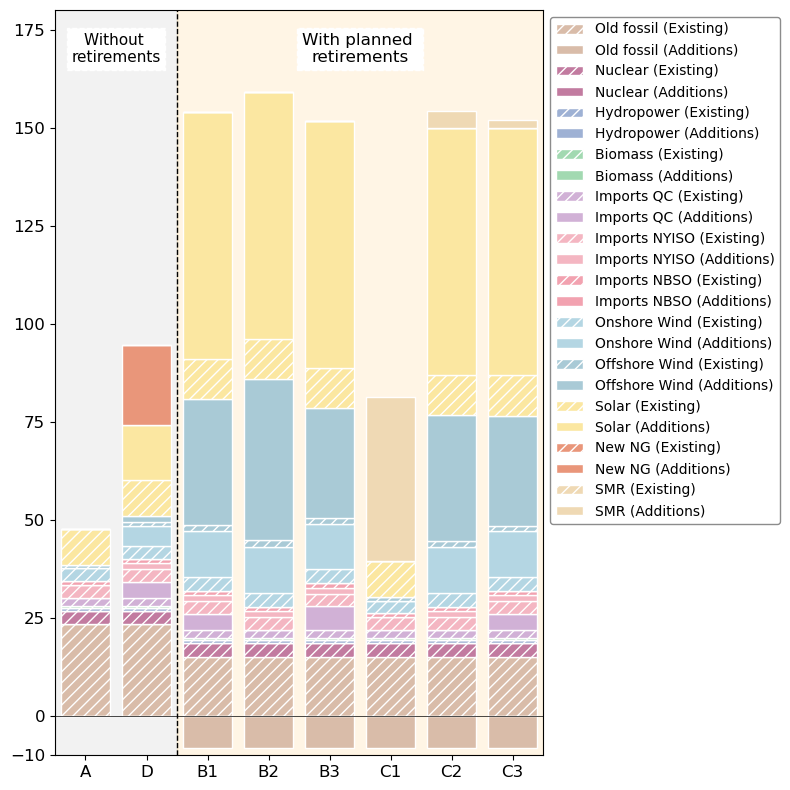

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define Colors and Order for Stacking
colors = {
    "Old fossil": "#D9BCA9",
    "New NG": "#E9967A",
    "Nuclear": "#C27BA0",
    "SMR": "#EFD9B4",
    "Hydropower": "#9EB1D4",
    "Biomass": "#A2D9B1",
    "Imports QC": "#D1B1D6",
    "Imports NYISO": "#F4B6C2",
    "Imports NBSO": "#F2A2B0",
    "Solar": "#FBE7A1",
    "Onshore Wind": "#B4D6E3",
    "Offshore Wind": "#A9CAD6"
}

columns_ordered = [
    'Old fossil', 'Nuclear', 'Hydropower', 'Biomass', 'Imports QC',
    'Imports NYISO', 'Imports NBSO', 'Onshore Wind',
    'Offshore Wind', 'Solar', 'New NG', 'SMR'
]

# Extract unique pathways
pathways = list(df_2050_capacity["Pathway"].unique())

# Reorder: Move "Pathway D" right after "Pathway A"
if "Pathway A" in pathways and "Pathway D" in pathways:
    pathways.remove("Pathway D")
    index_A = pathways.index("Pathway A")
    pathways.insert(index_A + 1, "Pathway D")  # Insert Pathway D right after Pathway A

# Reorder DataFrame manually (prevents unwanted sorting)
df_2050_capacity = df_2050_capacity.set_index("Pathway").loc[pathways].reset_index()

# Initialize DataFrame for plotting
plot_data = pd.DataFrame(index=pathways, columns=columns_ordered)

# Populate data for existing and additions
for pathway in pathways:
    for col in columns_ordered:
        existing_value = (
            df_2050_capacity[df_2050_capacity["Pathway"] == pathway][f"{col} Existing"].values[0] 
            / 1000  # Convert MW to GW
        )
        additions_value = (
            df_2050_capacity[df_2050_capacity["Pathway"] == pathway][f"{col} Additions"].values[0] 
            / 1000  # Convert MW to GW
        )
        plot_data.at[pathway, col] = (existing_value, additions_value)

# Ensure order is maintained
plot_data.index = pathways  # Set the manually ordered pathways

# Plot the final stacked bar chart
fig, ax = plt.subplots(figsize=(8, 8))
x = np.arange(len(plot_data))

# Initialize bottom stacking values
bottom_vals = np.zeros(len(x))

# Plot each technology as two stacked bars: Existing (hashed) + Additions (solid)
for col in columns_ordered:
    existing_values = np.array([plot_data.at[pathway, col][0] for pathway in pathways])
    additions_values = np.array([plot_data.at[pathway, col][1] for pathway in pathways])

    # Plot Existing Capacity with Hatching
    ax.bar(
        x, existing_values, bottom=bottom_vals, color=colors[col],
        edgecolor="white", hatch="///", label=f"{col} (Existing)"
    )
    bottom_vals += existing_values

    # Plot Additions on Top
    ax.bar(
        x, additions_values, bottom=bottom_vals, color=colors[col],
        edgecolor="white", label=f"{col} (Additions)"
    )
    bottom_vals += additions_values

# Add vertical separator
ax.axvline(x=1.5, color="black", linewidth=1, linestyle="--")

# Add shaded regions
ax.add_patch(plt.Rectangle((-0.5, -10), 2, 190, color="gray", alpha=0.1, zorder=-1))
ax.add_patch(plt.Rectangle((1.5, -10), 6, 190, color="orange", alpha=0.1, zorder=-1))

# Add text boxes
ax.text(0.5, 170, "Without \nretirements", fontsize=11, ha='center', va='center',
        bbox=dict(boxstyle='square', facecolor='white', edgecolor='white', linestyle='--'))
ax.text(4.5, 170, "With planned \nretirements", fontsize=12, ha='center', va='center',
        bbox=dict(boxstyle='square', facecolor='white', edgecolor='white', linestyle='--'))

# Add a solid horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.5)

# Labels and formatting
#ax.set_ylabel("Installed capacity in 2050 (GW)", fontsize=14)
#ax.set_xlabel("Pathway", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(plot_data.index, fontsize=12, rotation=0, ha='center')
ax.tick_params(axis='y', labelsize=12)

# Add more ticks on the y-axis (every 20 GW, for example)
import numpy as np
import matplotlib.ticker as ticker

class CustomLocator(ticker.Locator):
    def __call__(self):
        # Get the current view limits of the y-axis
        vmin, vmax = self.axis.get_view_interval()
        ticks = []
        
        # For the negative portion: ticks every 10
        if vmin < 0:
            # Start at the next multiple of 10 below vmin
            neg_start = np.floor(vmin / 10) * 10
            # Create ticks up to 0 (non-inclusive if 0 is computed again)
            neg_ticks = np.arange(neg_start, 0, 10)
            ticks.extend(neg_ticks)
        
        # For the positive portion: ticks every 25 (including 0)
        pos_ticks = np.arange(0, vmax + 25, 25)
        ticks.extend(pos_ticks)
        
        return ticks

# Then, set your locator and limits on your axis:
ax.yaxis.set_major_locator(CustomLocator())
ax.set_ylim(-10, 180)

ax.set_xlim(-0.5, 7.5)

# ----------------------------------------------------------------
# Plot Old fossil additions if negative, below zero (same color as Old fossil)
old_fossil_additions = np.array([plot_data.at[pathway, "Old fossil"][1] for pathway in pathways])
ax.bar(
    x, old_fossil_additions, bottom=0, 
    color=colors["Old fossil"],  # Use the same color as Old fossil
    edgecolor="white", label="Old fossil (Additions Negative)"
)
# Extend y-axis if negative additions go below zero
ymin, ymax = ax.get_ylim()
ax.set_ylim(min(ymin, old_fossil_additions.min() * 1.1), ymax)
# ----------------------------------------------------------------

# Collect legend handles/labels
handles, labels = ax.get_legend_handles_labels()

# We only want each label once, in a specific order: 
#  (col) (Existing), (col) (Additions), and at the end Old fossil (Additions Negative).
def get_handle(label, handles, labels):
    """Helper to retrieve the handle for a given label."""
    for h, l in zip(handles, labels):
        if l == label:
            return h
    return None

final_labels = []
final_handles = []

for col in columns_ordered:
    # existing
    e_label = f"{col} (Existing)"
    e_handle = get_handle(e_label, handles, labels)
    if e_handle is not None:
        final_labels.append(e_label)
        final_handles.append(e_handle)
    # additions
    a_label = f"{col} (Additions)"
    a_handle = get_handle(a_label, handles, labels)
    if a_handle is not None:
        final_labels.append(a_label)
        final_handles.append(a_handle)

# Finally, handle the Old fossil (Additions Negative) if present
neg_label = "Old fossil (Retirements)"
neg_handle = get_handle(neg_label, handles, labels)
if neg_handle is not None:
    final_labels.append(neg_label)
    final_handles.append(neg_handle)

ax.legend(
    final_handles, final_labels,
    loc='upper left', bbox_to_anchor=(1, 1),
    frameon=True, framealpha=0.9, fancybox=True, edgecolor='grey'
)


plt.tight_layout()
plt.savefig('Decarbonization_pathways.svg', dpi=300, bbox_inches='tight')
plt.show()


In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Custom legend mapping for technology names
legend_mapping = {
    "Old fossil": "Fossil fuels (incl. existing/retired \ncoal, oil, natural gas and wood)",
    "Nuclear": "Large nuclear",
    "Hydropower": "Hydropower",
    "Biomass": "Biomass",
    "Imports QC": "Imports from Hydro-Québec",
    "Imports NYISO": "Imports from NYISO",
    "Imports NBSO": "Imports from NBSO",
    "Onshore Wind": "Onshore wind",
    "Offshore Wind": "Offshore wind",
    "Solar": "Solar",
    "New NG": "Natural gas",
    "SMR": "SMRs"
}

# Ordered list of technologies (keys in legend_mapping)
columns_ordered = [
    'Old fossil', 'Nuclear', 'Hydropower', 'Biomass',
    'Imports QC', 'Imports NYISO', 'Imports NBSO',
    'Onshore Wind', 'Offshore Wind', 'Solar', 'New NG', 'SMR'
]

# Define colors for each technology
colors = {
    "Old fossil": "#D9BCA9",
    "New NG": "#E9967A",
    "Nuclear": "#C27BA0",
    "SMR": "#EFD9B4",
    "Hydropower": "#9EB1D4",
    "Biomass": "#A2D9B1",
    "Imports QC": "#D1B1D6",
    "Imports NYISO": "#F4B6C2",
    "Imports NBSO": "#F2A2B0",
    "Solar": "#FBE7A1",
    "Onshore Wind": "#B4D6E3",
    "Offshore Wind": "#A9CAD6"
}

# Create dummy handles to act as headers
dummy_tech = mlines.Line2D([], [], color="none", label="Technologies:")
dummy_cap = mlines.Line2D([], [], color="none", label="Capacity:")

# Create patches for each technology using the custom names
tech_patches = [mpatches.Patch(color=colors[tech], label=legend_mapping.get(tech, tech))
                for tech in columns_ordered]

# Create capacity patches: Existing (hatched) and Additions (solid)
existing_patch = mpatches.Patch(facecolor="black", edgecolor="white", hatch="///", label="Existing")
additions_patch = mpatches.Patch(facecolor="black", edgecolor="white", label="Additions or Retirements")

# Combine the handles into a single list:
combined_handles = [dummy_tech] + tech_patches + [dummy_cap] + [existing_patch, additions_patch]

# Create a dummy figure and axis solely for the legend
fig, ax = plt.subplots(figsize=(5, 8))
legend = ax.legend(handles=combined_handles, loc="center", frameon=False)
ax.axis("off")  # Hide the axis

# Save the combined legend as an SVG file
fig.savefig("Combined_Legend.svg", bbox_inches="tight", dpi=300)
plt.close(fig)
